In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
seed = 123
rng = np.random.default_rng(seed)
import scipy.signal as sig

import IPython.display as ipd
import matplotlib.pyplot as plt

from hr.util import synth_sine, esprit, least_squares, \
    psd_noise, noise_filtre_coeffs, whiten, _PINK_FILTRE_COEFFS, \
    ester_inverse_error_func, ester
from util.util import to_db

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simple noiseless 'harmonic' signal

In [3]:
sr = 44100
n_s = 100000
n_fft = 1024

r = 8 # number of sinusoids

deltas = rng.uniform(0.001, 0.01, r)
nus = rng.normal(0.1, 0.05, r)
amps = rng.uniform(0.1, 1, r)
phis = rng.uniform(0, 2*np.pi, r)

x_sine = synth_sine(n_s, deltas, nus, amps, phis) 

print(nus * sr)
print(deltas * sr)

[3711.90703018 3699.13199887 4624.25393767 1045.32345363 7038.72625954
 2930.24726624 6615.59407035 4710.5880781 ]
[314.92545452  65.46156236 131.5608335  117.27717167 113.91705214
 366.42030969 410.57562972 153.87237849]


/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


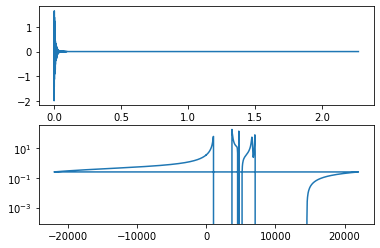

In [4]:
ts_plot = np.arange(n_s) / sr # times in seconds
nus_plot = np.fft.fftfreq(n_fft)

_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft)

plt.figure()
x_sine_ft = np.fft.fft(x_sine, n=n_fft)
plt.title("Time and frequency representation of the synthesised signal")
plt.subplot(2, 1, 1)
plt.plot(ts_plot, np.real(x_sine))
plt.subplot(2, 1, 2)
plt.semilogy(nus_plot * sr, x_sine_ft)

In [5]:
ipd.Audio(np.real(x_sine), rate=sr)

### Adding noise

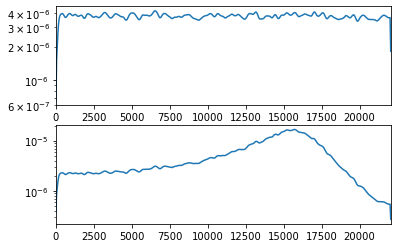

In [6]:
white_noise = rng.random(n_s)
pink_noise = sig.lfilter(_PINK_FILTRE_COEFFS["b"], _PINK_FILTRE_COEFFS["a"], white_noise)

fs_psd, white_noise_psd = sig.welch(white_noise, fs=sr, nfft=n_fft)
_, pink_noise_psd = sig.welch(pink_noise, fs=sr, nfft=n_fft)

plt.figure()
plt.title("White and pink noises")
plt.subplot(2, 1, 1)
plt.semilogy(fs_psd, white_noise_psd)
plt.xlim(np.array([0, 0.5])*sr)
plt.subplot(2, 1, 2)
plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(fs_psd, pink_noise_psd)
plt.show()

/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


width=1323.0 Hz


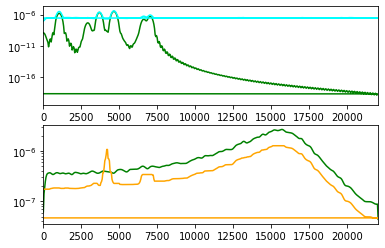

In [30]:
noise_ratio = 0.4
noise = noise_ratio*pink_noise
x = x_sine + noise

fs_x_psd, x_psd = sig.welch(x, fs=sr, nfft=n_fft)
fs_noise_psd, noise_psd = sig.welch(noise, fs=sr, nfft=n_fft)

nu_width = 0.03
ar_ordre = 14
print(f"width={nu_width*sr} Hz")
noise_psd_est = psd_noise(x_psd, nu_width=nu_width)


noise_filtre_coeffs_est = noise_filtre_coeffs(x, n_fft=n_fft, nu_width=nu_width, ar_ordre=ar_ordre)
# TODO: compare
# print(_PINK_FILTRE_COEFFS)
# print(noise_filtre_coeffs_est)
x_white = whiten(x, n_fft=n_fft, nu_width=nu_width, ar_ordre=ar_ordre)
_, x_white_psd = sig.welch(x_white, fs=sr, nfft=n_fft)
_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft)

plt.title("PSD of the noised synthesised signal")
plt.subplot(2, 1, 1)
plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(fs_x_psd, x_sine_psd, c='green')
plt.semilogy(fs_x_psd, x_white_psd, c='cyan')
plt.subplot(2, 1, 2)
plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(fs_noise_psd, noise_psd, c='green')
plt.semilogy(fs_x_psd, noise_psd_est, c='orange')
plt.show()

In [26]:
ipd.Audio(np.real(x), rate=sr)


### ESM model ordre estimation

#### Does not seem to be resistant to noise!

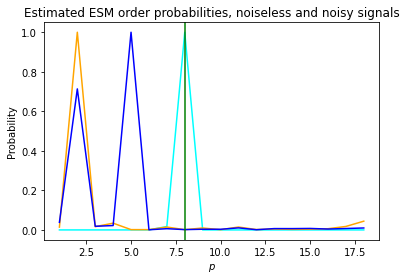

Order of the ESM model
Truth=8
Estimated: Noiseless=8, Noisy=2, Whitened=5


In [11]:
n_est = 20
p_max = n_est - 2 # for now
ps = np.arange(1,p_max+1)
j_sine = ester_inverse_error_func(x_sine, n=n_est, p_max=p_max)
j_noise = ester_inverse_error_func(x, n=n_est, p_max=p_max)
j_white = ester_inverse_error_func(x_white, n=n_est, p_max=p_max)

plt.figure()
plt.title('Estimated ESM ordre probabilities, noiseless and noisy signals')
plt.xlabel('$p$')
plt.ylabel('Probability')
plt.plot(ps, j_sine/np.max(j_sine), c='cyan')
plt.plot(ps, j_noise/np.max(j_noise), c='orange')
plt.plot(ps, j_white/np.max(j_white), c='b')
plt.axvline(r, ymin=0, ymax=1, c='g')
plt.show()

r_est_sine = ester(x_sine, n_est, p_max)
r_est_noise = ester(x, n_est, p_max)
r_est_white = ester(x_white, n_est, p_max)
print('Ordre of the ESM model')
print(f'Truth={r}')
print(f'Estimated: Noiseless={r_est_sine}, Noisy={r_est_noise}, Whitened={r_est_white}')


### Test of the model with noiseless signal

[0.08417023 0.08388054 0.10485837 0.02370348 0.15960831 0.06644552
 0.15001347 0.10681606]
[0.00031396 0.02469133 0.0837981  0.10647453 0.15680631]
[0.00714117 0.00148439 0.00298324 0.00265935 0.00258315 0.00830885
 0.0093101  0.00348917]
[6.21343975e-05 2.33529562e-03 4.23709022e-03 1.19383454e-03
 9.47867022e-03]


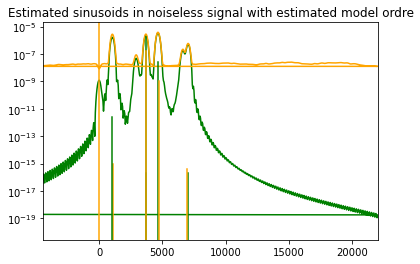

In [24]:
deltas_est, nus_est = esprit(x_white, n_est, r_est_white)
amps_est, phis_est = least_squares(x_white, deltas, nus)

print(nus)
print(nus_est)
print(deltas)
print(deltas_est)

plt.title("Estimated sinusoids in noiseless signal with estimated model ordre")
plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(fs_x_psd, x_sine_psd, c='g')
plt.semilogy(fs_x_psd, x_white_psd, c='orange')
for j in range(len(nus_est)):
    plt.axvline(nus[j] * sr, 0, amps[j], c='g')
    plt.axvline(nus_est[j] * sr, 0, amps_est[j], c='orange')
plt.show()

### Filter bank

In [14]:
# number of bands
n_fb = 32
m_fb = n_fb//2
step_fb = 1

fs_fb, ts_fb, x_stft = sig.stft(x_sine, fs=sr,
    nperseg=m_fb, nfft=n_fb)

fs_centre = np.fft.fftfreq(n=n_fb)

rs = [None] * n_fb
deltas_est = []
nus_est = []
amps_est = []
phis_est = []
for k in range(len(fs_centre)):
    x_b = x_stft[k]
    rs[k] = ester(x_b, n=n_est, p_max=p_max)
    deltas_est_band, nus_est_band = esprit(x_sine, n_est, rs[k])
    amps_est_band, phis_est_band = least_squares(x_sine, deltas, nus)
    nus_est_band += fs_centre[k]
    nus_est += nus_est_band.tolist()
    deltas_est += deltas_est_band.tolist()
    amps_est += amps_est_band.tolist()
    phis_est += phis_est_band.tolist()
nus_est = np.sort(nus_est)
print(rs)
print(nus_est)
# rs = ester(x_stft, n=n_est, p_max=p_max)


/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[-0.7941035  -0.7628535  -0.7316035  -0.7003535  -0.6691035  -0.6378535
 -0.6066035  -0.5753535  -0.5441035  -0.5128535  -0.4816035  -0.47629652
 -0.4503535  -0.44504652 -0.43355448 -0.4191035  -0.41611914 -0.41582974
 -0.41379652 -0.40230448 -0.39514163 -0.39318394 -0.3878535  -0.38486914
 -0.38457974 -0.38254652 -0.37105448 -0.36389163 -0.36193394 -0.3566035
 -0.35361914 -0.35332974 -0.35129652 -0.34998653 -0.34039169 -0.33980448
 -0.33264163 -0.33068394 -0.3253535  -0.32236914 -0.32207974 -0.32004652
 -0.31873653 -0.30914169 -0.30855448 -0.30139163 -0.29943394 -0.2941035
 -0.29111914 -0.29082974 -0.28879652 -0.28748653 -0.27789169 -0.27730448
 -0.27014163 -0.26818394 -0.2628535  -0.25986914 -0.25957974 -0.25754652
 -0.25623653 -0.24664169 -0.24605448 -0.23889163 -0.23693394 -0.2316035
 -0.22861914 -0.22832974 -0.22629652 -0.22498653 -0.21539169 -0.21480448
 -0.20764163 -0.20568394 -0.200